# PIRT Camera 

In [1]:
from imagedaemon import registry
available_cameras = registry.available()
print("Registered cameras:", available_cameras)

# check the camera parameters
for camname in available_cameras:
    camera = registry.get(camname)
    print("camera:")
    for entry in camera.meta:
        print(f"\t {entry}")

PROJECT_ROOT = /Users/nlourie/Desktop/Work/MIT/WINTER/GIT/winter-image-daemon/imagedaemon
CONFIG_DIR = /Users/nlourie/Desktop/Work/MIT/WINTER/GIT/winter-image-daemon/imagedaemon/config
Registered cameras: ['pirt', 'qcmos', 'summer-ccd', 'winter']
camera:
	 ('name', 'pirt')
	 ('pixel_scale', 0.411)
	 ('cal_steps', {'dark': True, 'lab_flat': False, 'dither_flat': False, 'sky_flat': False, 'remove_horizontal_stripes': False, 'mask': False, 'mask_hot_pixels': True, 'replace_nans_with_median': False, 'replace_nans_with_local_median': False})
	 ('focus_cal_steps', {'dark': True, 'lab_flat': False, 'dither_flat': False, 'sky_flat': False, 'remove_horizontal_stripes': False, 'mask': False, 'mask_hot_pixels': True, 'replace_nans_with_median': False, 'replace_nans_with_local_median': False})
	 ('sex_cfg_dir', PosixPath('/Users/nlourie/Desktop/Work/MIT/WINTER/GIT/winter-image-daemon/imagedaemon/config'))
	 ('scale_margin', 0.05)
	 ('hot_pixel_threshold', 14000)
	 ('focus_addrs', [])
camera:
	 ('n

In [2]:
# PIRT Pipeline
import os
pirt = registry.get("pirt")

dark_dir = os.path.join(os.path.expanduser("~"), "data", "image-daemon-data",
                        "raw", "pirt","commissioning", "20250803", "darks")





In [3]:
# Make the master darks
pirt.build_master_frames(src_dir=dark_dir,
                         obstype = "dark")

[I root] Combining 10 DARK frames at exposure time=1.0


                                             filepath  \
0   /Users/nlourie/data/image-daemon-data/raw/pirt...   
1   /Users/nlourie/data/image-daemon-data/raw/pirt...   
2   /Users/nlourie/data/image-daemon-data/raw/pirt...   
3   /Users/nlourie/data/image-daemon-data/raw/pirt...   
4   /Users/nlourie/data/image-daemon-data/raw/pirt...   
5   /Users/nlourie/data/image-daemon-data/raw/pirt...   
6   /Users/nlourie/data/image-daemon-data/raw/pirt...   
7   /Users/nlourie/data/image-daemon-data/raw/pirt...   
8   /Users/nlourie/data/image-daemon-data/raw/pirt...   
9   /Users/nlourie/data/image-daemon-data/raw/pirt...   
10  /Users/nlourie/data/image-daemon-data/raw/pirt...   
11  /Users/nlourie/data/image-daemon-data/raw/pirt...   
12  /Users/nlourie/data/image-daemon-data/raw/pirt...   
13  /Users/nlourie/data/image-daemon-data/raw/pirt...   
14  /Users/nlourie/data/image-daemon-data/raw/pirt...   
15  /Users/nlourie/data/image-daemon-data/raw/pirt...   
16  /Users/nlourie/data/image-d

[I root]   --> pirt_masterdark_1.000s.fits
[I root] Combining 10 DARK frames at exposure time=10.0
[I root]   --> pirt_masterdark_10.000s.fits
[I root] Combining 10 DARK frames at exposure time=30.0
[I root]   --> pirt_masterdark_30.000s.fits
[I root] Combining 10 DARK frames at exposure time=60.0
[I root]   --> pirt_masterdark_60.000s.fits
[I root] Combining 10 DARK frames at exposure time=120.0
[I root]   --> pirt_masterdark_120.000s.fits


[I imagedaemon.pipeline] Calibration started | camera=pirt image=/Users/nlourie/data/images/pirt_commissioning_data_pkg/science/WNTR25fejjz/scicam_20250804T111208.fits


Science image: /Users/nlourie/data/images/pirt_commissioning_data_pkg/science/WNTR25fejjz/scicam_20250804T111208.fits
running _calibrate_data with addr=None
[DEBUG][None] raw: finite=1310720/1310720, min=265, max=1.62e+04
[DEBUG][None] after dark: finite=1310720/1310720, min=-3.57e+03, max=1.09e+04
[DEBUG][None] after hot pixel mask: finite=1310720/1310720, min=-3.57e+03, max=1.09e+04


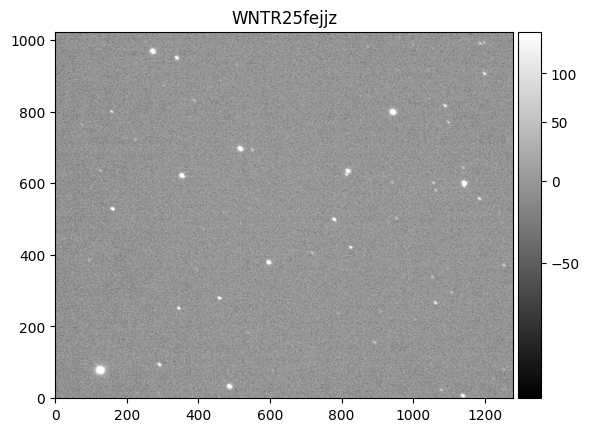

In [ ]:
# Try to run the cal pipeline on a dither set
import os
from glob import glob
targetName = "WNTR25fejjz"
science_dir = os.path.join(os.path.expanduser("~"), "data", 
                           "images", "pirt_commissioning_data_pkg", 
                           "science",targetName)

science_image = glob(os.path.join(science_dir, "*.fits"))[0]


print("Science image:", science_image)

callimg = pirt.calibrate_image(science_image = science_image
                               ,
                               )
callimg.plot_image(title = targetName)

calimg_savepath = os.path.join(science_dir, f"{targetName}_calibrated.fits")
callimg.save_image(calimg_savepath)




In [ ]:
# Run astrometry
# run the full astrometric pipeline
output_dir = os.path.join(os.path.join(os.getenv("HOME"), "data", "tmp"))

info = pirt.get_astrometric_solution(science_image = science_image,
                                      output_dir = output_dir,
                                      #ra = 9.88,
                                      #dec = 41.19,
    )

wcs = info["wcs"]

print("WCS:", wcs)



In [ ]:
# Focus attempt
from imagedaemon.utils.image import Image
from glob import glob
focus_dir = os.path.join(os.path.expanduser("~"), "data", "image-daemon-data",
                        "raw", "pirt",
                        "commissioning", "20250803", "focus")
focus_images = glob(os.path.join(focus_dir, "*.fits"))

# plot one
img = Image(focus_images[0])
img.plot_image(title = f"Focus Image: {img.filename}\nFocus Position: {img.header['FOCPOS']:.0f}",)

print(f"Focus images: {focus_images}")
print(f"type(focus_images): {type(focus_images)}")
res = pirt._load_focus_images(focus_images)
print(f"Focus images loaded: {res}")
# calibrate all the focus images
focus_calibrated = pirt.calibrate_for_focus(
    image_paths = focus_images,
    out_dir = os.path.join(os.path.expanduser("~"), "data", "tmp"),
)

print(f"Focus calibrated images: {focus_calibrated}")

# now try for a focus loop

results = pirt.run_focus_loop(image_list = focus_images,
                                   addrs = None,
                                   output_dir = os.path.join(os.path.expanduser("~"), "data", "tmp"),
)

print(f"Focus loop results: {results}")

# plot the first one
#focus_calibrated[0].plot_image(f"First Focus Calibrated Image: {focus_calibrated[0].filename}",)

In [ ]:
from imagedaemon import registry
import os
from glob import glob
available_cameras = registry.available()
print("Registered cameras:", available_cameras)

# check the camera parameters
for camname in available_cameras:
    camera = registry.get(camname)
    print("camera:")
    for entry in camera.meta:
        print(f"\t {entry}")

pirt = registry.get("pirt")
science_dir = os.path.join(os.path.expanduser("~"), "data", "image-deamon-data",
                           "raw", "pirt","commissioning", "20250803", "science","WNTR25fejjz")

Registered cameras: ['pirt', 'qcmos', 'summer-ccd', 'winter']
camera:
	 ('name', 'pirt')
	 ('pixel_scale', 0.411)
	 ('cal_steps', {'dark': True, 'lab_flat': False, 'dither_flat': False, 'sky_flat': False, 'remove_horizontal_stripes': False, 'mask': False, 'mask_hot_pixels': True, 'replace_nans_with_median': False, 'replace_nans_with_local_median': False})
	 ('focus_cal_steps', {'dark': True, 'lab_flat': False, 'dither_flat': False, 'sky_flat': False, 'remove_horizontal_stripes': False, 'mask': False, 'mask_hot_pixels': True, 'replace_nans_with_median': False, 'replace_nans_with_local_median': False})
	 ('sex_cfg_dir', PosixPath('/Users/nlourie/Desktop/Work/MIT/WINTER/GIT/winter-image-daemon/imagedaemon/config'))
	 ('scale_margin', 0.05)
	 ('hot_pixel_threshold', 14000)
	 ('focus_addrs', [])
camera:
	 ('name', 'qcmos')
	 ('pixel_scale', 0.157)
	 ('cal_steps', {'dark': False, 'lab_flat': False, 'dither_flat': False, 'sky_flat': False, 'remove_horizontal_stripes': False, 'mask': False, 'm